<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px">

# Recurrent Neural Networks (RNNs)

_Author: Riley Dallas (ATX)_

---


### Learning Objectives

- Learn how to train/test split for sequence data
- Use `TimeseriesGenerator` to prep our time series data for modeling
- Create a basic RNN model using `keras`

In [1]:
import pandas as pd

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, GRU
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

import matplotlib.pyplot as plt
%matplotlib inline


Bad key "text.kerning_factor" on line 4 in
/Users/ryanchangky/opt/anaconda3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.3/matplotlibrc.template
or from the matplotlib source distribution


## Load data: AAPL stock prices and SEC filings
---

There are two datasets that we'll merge together:
- Apple's historical stock prices (ticker: AAPL)
- Their SEC filings:
  - Annual earnings reports: 10-K
  - Quarterly earnings reports: 10-Q
  - Company news and updates: 8-K

Load both in the cells below.

In [2]:
# load prices
prices = pd.read_csv('./datasets/AAPL.csv')
prices.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2005-04-25,5.212857,5.288571,5.158571,5.282857,3.522625,186615100
1,2005-04-26,5.254286,5.358572,5.160000,5.170000,3.447372,202626900
2,2005-04-27,5.127143,5.194286,5.072857,5.135714,3.424510,153472200
3,2005-04-28,5.184286,5.191429,5.034286,5.077143,3.385454,143776500
4,2005-04-29,5.164286,5.175714,5.031428,5.151429,3.434988,167907600


In [3]:
# load filings
filings = pd.read_csv('./datasets/filings.csv')
filings.head()

,Date,10-K,10-Q,8-K
0,1994-12-13,1.0,0.0,0.0
1,1995-12-19,1.0,0.0,0.0
2,1996-12-19,1.0,0.0,0.0
3,1997-12-05,1.0,0.0,0.0
4,1999-12-22,1.0,0.0,0.0


In [4]:
filings.dtypes

Date     object
10-K    float64
10-Q    float64
8-K     float64
dtype: object

## `Date` columns
---

For both datasets, we need to:
1. Convert the `Date` column to be a `datetime` object
2. Since these are time series datasets, we need the indices to be the `Date` columns

In [5]:
# set prices Date to datetime
prices['Date'] = pd.to_datetime(prices['Date'])

In [6]:
# set prices index to Date column
prices.set_index('Date', inplace=True)
prices.sort_index(inplace=True)

In [7]:
prices.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2005-04-25,5.212857,5.288571,5.158571,5.282857,3.522625,186615100
2005-04-26,5.254286,5.358572,5.160000,5.170000,3.447372,202626900
2005-04-27,5.127143,5.194286,5.072857,5.135714,3.424510,153472200
2005-04-28,5.184286,5.191429,5.034286,5.077143,3.385454,143776500
2005-04-29,5.164286,5.175714,5.031428,5.151429,3.434988,167907600


In [8]:
# set filings Date to datetime
filings['Date'] = pd.to_datetime(filings['Date'])

In [9]:
# set filings index to Date column
filings.set_index('Date', inplace=True)
filings.sort_index(inplace=True)

In [10]:
filings.head()

,10-K,10-Q,8-K
Date,,,
1994-12-13,1.0,0.0,0.0
1995-12-19,1.0,0.0,0.0
1996-12-19,1.0,0.0,0.0
1997-12-05,1.0,0.0,0.0
1999-12-22,1.0,0.0,0.0


## Data cleaning: Prices
---

For Apple's stock prices, we'll need to do a few things:
1. Drop the `Adj Close` column since we already have a `Close` price
2. De-trend the dataset using `.pct_change()`
3. Drop any `NaN`s that were created from step 2

In [11]:
# Drop Adj Close column
prices.drop(columns='Adj Close', inplace=True)

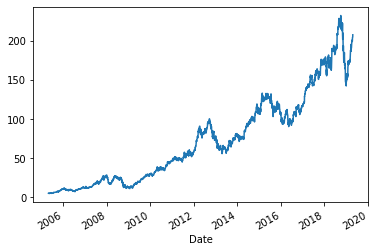

In [12]:
# Plot Close column
prices['Close'].plot()

In [13]:
prices.head()

,Open,High,Low,Close,Volume
Date,,,,,
2005-04-25,5.212857,5.288571,5.158571,5.282857,186615100
2005-04-26,5.254286,5.358572,5.160000,5.170000,202626900
2005-04-27,5.127143,5.194286,5.072857,5.135714,153472200
2005-04-28,5.184286,5.191429,5.034286,5.077143,143776500
2005-04-29,5.164286,5.175714,5.031428,5.151429,167907600


In [14]:
# Convert prices to be percent changes from prior row
prices = prices.pct_change()
prices.head()

,Open,High,Low,Close,Volume
Date,,,,,
2005-04-25,NaN,NaN,NaN,NaN,NaN
2005-04-26,0.007947,0.013236,0.000277,-0.021363,0.085801
2005-04-27,-0.024198,-0.030659,-0.016888,-0.006632,-0.242587
2005-04-28,0.011145,-0.000550,-0.007603,-0.011405,-0.063176
2005-04-29,-0.003858,-0.003027,-0.000568,0.014631,0.167838


In [15]:
# Drop nulls
prices.dropna(inplace=True)

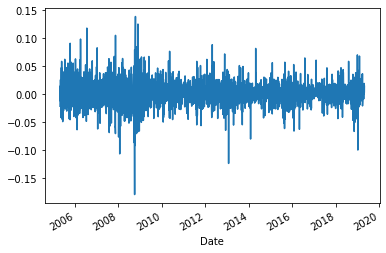

In [16]:
# Plot Close column again
prices['Close'].plot()

## Create `Target` column
---

Our column of interest is the `Close` prices. We could build a regression model, where we predict the actual percentage change, or we could set this up as a binary classification problem:
- 1: The `Close` price was greater than or equal to the previous day
- 0: The `Close` price was lower than the previous day

We'll go with the latter option. In the cell below, let's create our binary `Target` column.

In [17]:
# Create Target column
prices['Target'] = (prices['Close'] >0).astype(int)
prices.head()

,Open,High,Low,Close,Volume,Target
Date,,,,,,
2005-04-26,0.007947,0.013236,0.000277,-0.021363,0.085801,0
2005-04-27,-0.024198,-0.030659,-0.016888,-0.006632,-0.242587,0
2005-04-28,0.011145,-0.000550,-0.007603,-0.011405,-0.063176,0
2005-04-29,-0.003858,-0.003027,-0.000568,0.014631,0.167838,1
2005-05-02,0.001660,0.011593,0.022714,0.010261,-0.306285,1


## Merge Prices with SEC filings
---

SEC filings tend to have a huge impact on stock prices. Because of this, we'll want to merge the prices and filings `DataFrames` together.

**NOTE** We'll want to do a left join, so that we don't lose any rows that aren't associated with any SEC filings.

In [18]:
filings.tail(10)

,10-K,10-Q,8-K
Date,,,
2018-05-07,0.0,0.0,1.0
2018-07-31,0.0,0.0,1.0
2018-08-01,0.0,1.0,0.0
2018-11-01,0.0,0.0,1.0
2018-11-05,1.0,0.0,0.0
2019-01-02,0.0,0.0,1.0
2019-01-29,0.0,0.0,1.0
2019-01-30,0.0,1.0,0.0
2019-02-06,0.0,0.0,1.0


In [19]:
# Merge DataFrames
df = pd.merge(prices, filings, how ='left', left_index = True, right_index=True)

In [20]:
df.shape

(3522, 9)

In [21]:
df.tail(40)

,Open,High,Low,Close,Volume,Target,10-K,10-Q,8-K
Date,,,,,,,,,
2019-02-26,-0.002584,-0.003241,-0.004484,0.000574,-0.219591,1,NaN,NaN,NaN
2019-02-27,-0.002878,-0.001711,-0.002541,0.003098,0.630643,1,NaN,NaN,NaN
2019-02-28,0.006408,-0.000514,0.001100,-0.009836,0.013652,0,NaN,NaN,NaN
2019-03-01,-0.000230,0.001372,-0.000173,0.010511,-0.082551,1,NaN,NaN,NaN
2019-03-04,0.008090,0.014844,0.006247,0.005029,0.059877,1,0.0,0.0,1.0
2019-03-05,0.001423,-0.009845,0.003276,-0.001820,-0.280607,0,NaN,NaN,NaN
2019-03-06,-0.007218,-0.002898,-0.003438,-0.005754,0.054364,0,NaN,NaN,NaN
2019-03-07,-0.004580,-0.005983,-0.011038,-0.011575,0.189833,0,NaN,NaN,NaN
2019-03-08,-0.020417,-0.007854,-0.014649,0.002377,-0.030754,1,NaN,NaN,NaN


## Fill `NaN`s
---

After the merge, we now have a bunch of `NaN`s for rows that didn't have any SEC filings on that date. Let's fill those in with 0.

In [22]:
# Fill Nans with 0
df.fillna(0, inplace=True)

In [23]:
df.isnull().sum()

Open      0
High      0
Low       0
Close     0
Volume    0
Target    0
10-K      0
10-Q      0
8-K       0
dtype: int64

## Train/Test Split
---

Since we're dealing with time series data, we don't want the model to be able to see the future. 

**When using `train_test_split` on time series date, set `shuffle=False` so that the order is maintained.**

In [24]:
# Create X and y
features = [ col for col in df.columns if col !='Target' ]
X = df[features]
y = df['Target']

In [25]:
# Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(X,y,shuffle=False)
X_train.head()

,Open,High,Low,Close,Volume,10-K,10-Q,8-K
Date,,,,,,,,
2005-04-26,0.007947,0.013236,0.000277,-0.021363,0.085801,0.0,0.0,0.0
2005-04-27,-0.024198,-0.030659,-0.016888,-0.006632,-0.242587,0.0,0.0,0.0
2005-04-28,0.011145,-0.000550,-0.007603,-0.011405,-0.063176,0.0,0.0,0.0
2005-04-29,-0.003858,-0.003027,-0.000568,0.014631,0.167838,0.0,0.0,0.0
2005-05-02,0.001660,0.011593,0.022714,0.010261,-0.306285,0.0,0.0,0.0


In [26]:
X_test.tail()

,Open,High,Low,Close,Volume,10-K,10-Q,8-K
Date,,,,,,,,
2019-04-16,0.004431,0.007606,0.002778,0.000100,0.465301,0.0,0.0,0.0
2019-04-17,0.000401,0.009982,0.000252,0.019473,0.124936,0.0,0.0,0.0
2019-04-18,0.017941,0.003786,0.019687,0.003594,-0.162972,0.0,0.0,0.0
2019-04-22,-0.001428,0.003870,-0.000889,0.003287,-0.196575,0.0,0.0,0.0
2019-04-23,0.007888,0.013711,0.007710,0.014423,0.199053,0.0,0.0,0.0


## Scaling
---

You want to scale your data for any model that uses gradient descent, which includes neural networks.

In [27]:
# Scale
ss = StandardScaler()
X_train_sc = ss.fit_transform(X_train)
X_test_sc = ss.transform(X_test)

## `TimeseriesGenerator`
---

We'll now convert our data into series' using `TimeseriesGenerator`. The `length` parameter dictates how many rows will constitute a sample. The generator also creates our batches.

```python
train_sequences = TimeseriesGenerator(X_train_sc, y_train, length=3, batch_size=64)
```

In the cells below, convert your training and validation data into sequences.

In [28]:
# Create training sequences
train_sequences = TimeseriesGenerator(X_train_sc, y_train, length=3, batch_size=64)

In [29]:
X_train_sc.shape

(2641, 8)

In [30]:
len(train_sequences)

42

In [31]:
batch_x, batch_y = train_sequences[41]

In [32]:
batch_x.shape

(14, 3, 8)

In [33]:
batch_x[:2]

array([[[-1.00954502, -1.07385765, -0.69247865, -0.97469738,
         -0.32294705, -0.06165092, -0.10536889, -0.02752931],
        [-0.44312084, -0.58275618, -1.91180732, -1.44720099,
          0.86801783, -0.06165092, -0.10536889, -0.02752931],
        [-1.06634363, -1.02910339,  0.30216047,  0.4586576 ,
         -0.37741   , -0.06165092, -0.10536889, -0.02752931]],

       [[-0.44312084, -0.58275618, -1.91180732, -1.44720099,
          0.86801783, -0.06165092, -0.10536889, -0.02752931],
        [-1.06634363, -1.02910339,  0.30216047,  0.4586576 ,
         -0.37741   , -0.06165092, -0.10536889, -0.02752931],
        [-0.48684431, -1.02129443, -0.65630776, -0.36465685,
         -0.23924403, -0.06165092, -0.10536889, -0.02752931]]])

In [34]:
X_train_sc[:10]

array([[ 0.277762  ,  0.65593887, -0.05122123, -1.04709738,  0.0686483 ,
        -0.06165092, -0.10536889, -0.02752931],
       [-1.09289224, -1.76187057, -0.82999299, -0.36944379, -0.74627527,
        -0.06165092, -0.10536889, -0.02752931],
       [ 0.41411047, -0.10343687, -0.40875   , -0.58900501, -0.30105021,
        -0.06165092, -0.10536889, -0.02752931],
       [-0.22560522, -0.23987897, -0.08954562,  0.60869223,  0.27222848,
        -0.06165092, -0.10536889, -0.02752931],
       [ 0.00965554,  0.56540213,  0.96674707,  0.40762889, -0.90434694,
        -0.06165092, -0.10536889, -0.02752931],
       [ 0.1626248 ,  0.06212066, -0.05118983, -0.34218057,  0.01987682,
        -0.06165092, -0.10536889, -0.02752931],
       [-0.40082251,  0.61651522,  0.02435533,  1.12980892, -0.38688396,
        -0.06165092, -0.10536889, -0.02752931],
       [ 1.28502309,  0.03050838,  0.40121284, -0.64635927, -0.48098607,
        -0.06165092, -0.10536889, -0.02752931],
       [-0.47319798,  0.01553013

In [35]:
batch_y[:10]

array([0, 1, 1, 1, 0, 0, 1, 0, 1, 0])

In [36]:
y_train[3:10]

Date
2005-04-29    1
2005-05-02    1
2005-05-03    0
2005-05-04    1
2005-05-05    0
2005-05-06    1
2005-05-09    0
Name: Target, dtype: int64

In [37]:
# Create test sequences
test_sequences = TimeseriesGenerator(X_test_sc, y_test, length=3, batch_size=64)

In [38]:
X_test_sc.shape

(881, 8)

In [39]:
len(test_sequences) # (881-2) / 64

14

## Modeling time!
---

Now it's time to design our RNN model. We'll have:

- 2 `GRU` layers
- 2 hidden `Dense` layers
- 1 `Dense` output layer

We're doing a binary classification problem. As a result, our output layer needs to be 1 neuron, with the `sigmoid` activation function. This way, our model predicts a probability.

In [40]:
# Design RNN
model = Sequential()
model.add(GRU(8, input_shape=(3,8), return_sequences=True))
model.add(GRU(8))
model.add(Dense(4, activation='relu'))
#model.add(Dense(3, activation='relu'))
model.add(Dense(1, activation='sigmoid')) # output layer

In [41]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru (GRU)                    (None, 3, 8)              432       
_________________________________________________________________
gru_1 (GRU)                  (None, 8)                 432       
_________________________________________________________________
dense (Dense)                (None, 4)                 36        
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 5         
Total params: 905
Trainable params: 905
Non-trainable params: 0
_________________________________________________________________


In [42]:
model.compile(loss='binary_crossentropy', optimizer=Adam(lr=0.0005), metrics=['accuracy'])

In [44]:
history = model.fit(train_sequences, epochs=20, validation_data=test_sequences)

Epoch 1/20
42/42 [==============================] - 1s 28ms/step - loss: 0.6938 - accuracy: 0.4924 - val_loss: 0.6927 - val_accuracy: 0.5171
Epoch 2/20
42/42 [==============================] - 0s 9ms/step - loss: 0.6928 - accuracy: 0.5091 - val_loss: 0.6922 - val_accuracy: 0.5159
Epoch 3/20
42/42 [==============================] - 0s 8ms/step - loss: 0.6925 - accuracy: 0.5262 - val_loss: 0.6918 - val_accuracy: 0.5308
Epoch 4/20
42/42 [==============================] - 0s 8ms/step - loss: 0.6922 - accuracy: 0.5277 - val_loss: 0.6916 - val_accuracy: 0.5239
Epoch 5/20
42/42 [==============================] - 0s 8ms/step - loss: 0.6921 - accuracy: 0.5265 - val_loss: 0.6914 - val_accuracy: 0.5342
Epoch 6/20
42/42 [==============================] - 0s 8ms/step - loss: 0.6920 - accuracy: 0.5243 - val_loss: 0.6915 - val_accuracy: 0.5285
Epoch 7/20
42/42 [==============================] - 0s 11ms/step - loss: 0.6918 - accuracy: 0.5299 - val_loss: 0.6913 - val_accuracy: 0.5296
Epoch 8/20
42/42 [

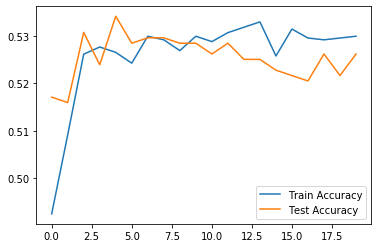

In [45]:
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Test Accuracy')
plt.legend()

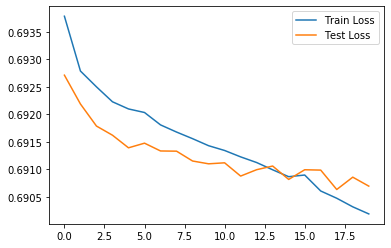

In [46]:
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Test Loss')
plt.legend()